In [1]:
# from train_autoencoder import *
import numpy as np
import matplotlib.pyplot as plt
# from mpcontribs.client import Client
plt.rcParams['text.usetex'] = True

# from mp_api.client import MPRester
import csv
import time
from h5 import *
from scipy.interpolate import RegularGridInterpolator, LinearNDInterpolator
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
# import torchsummary
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'


In [3]:
def save_checkpoint(checkpoint_path, model, optimizer):
    # state_dict: a Python dictionary object that:
    # - for a model, maps each layer to its parameter tensor;
    # - for an optimizer, contains info about the optimizer’s states and hyperparameters used.
    state = {
        'state_dict': model.state_dict(),
        'optimizer' : optimizer.state_dict()}
    torch.save(state, checkpoint_path)
    print('model saved to %s' % checkpoint_path)
    
def load_checkpoint(checkpoint_path, model, optimizer):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    print('model loaded from %s' % checkpoint_path)

In [4]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [5]:
def symm(X):
    return 0.25*(np.rot90(X,2).T + np.rot90(X,2) + X + X.T)

def plot_im(X):
    kx = np.linspace(-0.5, 0.5, 10)
    ky = np.linspace(-0.5, 0.5, 10)
    kx, ky = np.meshgrid(kx, ky)

    plt.figure(figsize=(5, 4))
    plt.contourf(kx, ky, X, levels=20, cmap='viridis')
    plt.colorbar(label='Energy (lower band)')
    # plt.title('Energy Band Structure (lower band)')
    plt.xlabel('$k_x$')
    plt.ylabel('$k_y$')
    plt.show()

def plot_train_process2(train_loss1, test_loss1, train_loss2, test_loss2):
    fig, axes = plt.subplots(1, 1, figsize=( 5, 3))

    # axes.set_title('Loss')
    axes.text(-0.2, 1.0, 'c)', transform=axes.transAxes,
        fontsize=10, fontweight='normal', va='top', ha='right')
    
    axes.plot(train_loss1, linestyle='solid', color='red', label='Train Flat')
    axes.plot(test_loss1,  linestyle='dashed', color='red', label='Test Flat')

    axes.plot(train_loss2, linestyle='solid', color='blue', label='Train Conv')
    axes.plot(test_loss2,  linestyle='dashed', color='blue', label='Test Conv')
    axes.set_xlim((0, 100))
    axes.set_xlabel('Epoch')
    axes.set_ylabel('Loss')
    fig.tight_layout()
    
    axes.legend()


def plot_train_process(train_loss, test_loss):
    fig, axes = plt.subplots(1, 1, figsize=( 5, 4))

    axes.set_title('Loss')
    axes.plot(train_loss, linestyle='solid', color='red', label='Train')
    axes.plot(test_loss,  linestyle='dashed', color='red', label='Test')
    axes.legend()

    # axes[1].set_title('Validation accuracy')
    # axes[1].plot(val_accuracy)

def plot2(X1, X2):
    fig, (ax,bx) = plt.subplots( 1,2, figsize=(5, 2), dpi=300)

    kx = np.linspace(-0.5, 0.5, 10)
    ky = np.linspace(-0.5, 0.5, 10)
    kx, ky = np.meshgrid(kx, ky)
    
    ax.text(-0.2, 1.0, 'a)', transform=ax.transAxes,
        fontsize=10, fontweight='normal', va='top', ha='right')
    im1 = ax.contourf(kx, ky, X1, levels=20, cmap='viridis')
    # ax.colorbar(label='E (eV)')
    
    divider = make_axes_locatable(bx)
    # divider = make_axes_locatable(ax)
    cbx = divider.append_axes('right', size='5%', pad=0.05)

    ax.set_xlabel('$k_x$')
    ax.set_ylabel('$k_y$')
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])

    im2 = bx.contourf(kx, ky, X2, levels=20, cmap='viridis')
    # bx.colorbar(label='E (eV)')
    bx.text(-0.2, 1.0, 'b)', transform=bx.transAxes,
        fontsize=10, fontweight='normal', va='top', ha='right')
    bx.set_xlabel('$k_x$')
    bx.set_ylabel('$k_y$')
    bx.xaxis.set_ticklabels([])
    bx.yaxis.set_ticklabels([])
    fig.colorbar(im2, cax=cbx, orientation='vertical')
    fig.tight_layout()

    plt.show()


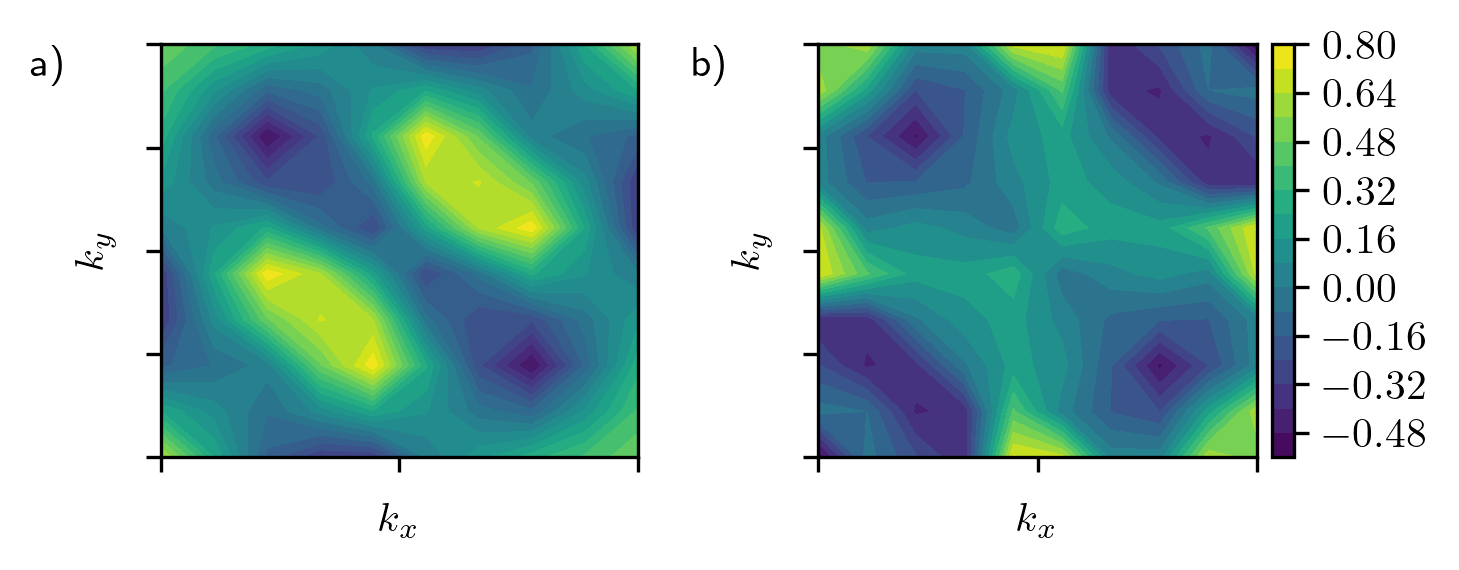

In [49]:
plot2(X_train_fin[10], random_decoded_output[0,0])


# DB

In [6]:
with HDFArchive('bs15533.h5','r') as datadict:
    X_train = np.array(datadict['data'])

In [7]:
X_train_mean = X_train - (np.sum(X_train, axis=(1,2))/100)[:, np.newaxis, np.newaxis]
X_train_fin = X_train_mean/np.std(X_train_mean, axis=(1, 2))[:, np.newaxis, np.newaxis]

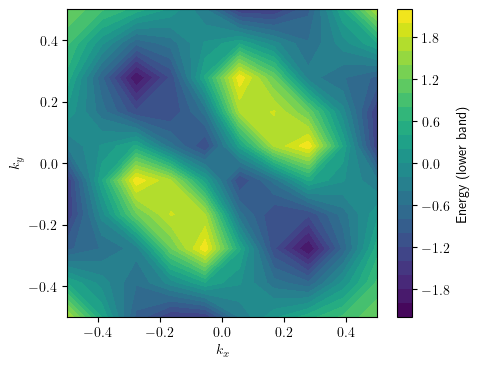

In [7]:
plot_im(X_train_fin[10])

In [8]:
X_data = np.reshape(np.array(X_train_fin), (15533, 1, 10, 10))
X_data = torch.tensor(X_data, dtype=torch.float32)
X_train, X_test, y_train, y_test = train_test_split(X_data, X_data, test_size=0.2, random_state=42)

dataset_train = TensorDataset(X_train, y_train)
dataset_test = TensorDataset(X_test, y_test)

dataloader_train = DataLoader(dataset_train, batch_size=1024, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=1024, shuffle=True)

In [9]:
def train_model(model, loss_func, opt, n_epochs: int):
    train_loss = []
    val_loss = []
    val_accuracy = []
    
    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []
        start_time = time.time()

        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in dataloader_train:
            # print(X_batch.shape)
            
            X_batch = X_batch.to(device, torch.float32)
            y_batch = y_batch.to(device, torch.float32)
            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            
            # print(X_batch)
            y_pred = model(X_batch)
            # print(y_pred)
            loss = loss_func(y_pred, y_batch)
            loss.backward()
            opt.step()
            opt.zero_grad()

            ep_train_loss.append(loss.item())

        
        model.train(False) # disable dropout / use averages for batch_norm
        with torch.no_grad():
            for X_batch, y_batch in dataloader_test:
                # move data to target device
                
                X_batch = X_batch.to(device, torch.float32)
                # compute predictions
                
                y_pred = model(X_batch)
                ep_val_loss.append( loss_func(y_pred, y_batch) )
                
        # print the results for this epoch:
        print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        
        print(f"\t  training loss: {train_loss[-1]:.6f}")
        print(f"\tvalidation loss: {val_loss[-1]:.6f}")
        
    return train_loss, val_loss, val_accuracy

# Flat

In [10]:
from models.autoenc_flat import Band_generator_flat

In [25]:
latent_dim = 7
learning_rate = 3e-4

model = Band_generator_flat(latent_dim=latent_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [26]:
n_epochs = 100
train_loss, test_loss, val_accuracy = train_model(model, criterion, optimizer, n_epochs)

Epoch 1 of 100 took 0.210s
	  training loss: 1.002637
	validation loss: 0.998011
Epoch 2 of 100 took 0.213s
	  training loss: 0.992885
	validation loss: 0.983939
Epoch 3 of 100 took 0.212s
	  training loss: 0.975318
	validation loss: 0.959319
Epoch 4 of 100 took 0.190s
	  training loss: 0.947310
	validation loss: 0.931291
Epoch 5 of 100 took 0.230s
	  training loss: 0.903155
	validation loss: 0.875611
Epoch 6 of 100 took 0.134s
	  training loss: 0.846163
	validation loss: 0.815242
Epoch 7 of 100 took 0.153s
	  training loss: 0.790689
	validation loss: 0.772604
Epoch 8 of 100 took 0.143s
	  training loss: 0.745939
	validation loss: 0.743397
Epoch 9 of 100 took 0.156s
	  training loss: 0.709623
	validation loss: 0.715826
Epoch 10 of 100 took 0.150s
	  training loss: 0.690548
	validation loss: 0.685202
Epoch 11 of 100 took 0.258s
	  training loss: 0.669690
	validation loss: 0.643235
Epoch 12 of 100 took 0.143s
	  training loss: 0.647772
	validation loss: 0.629403
Epoch 13 of 100 took 0.15

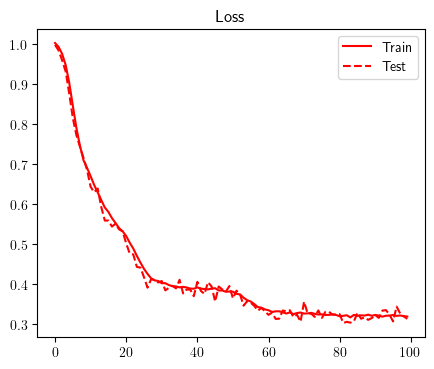

In [27]:
plot_train_process(train_loss, test_loss)

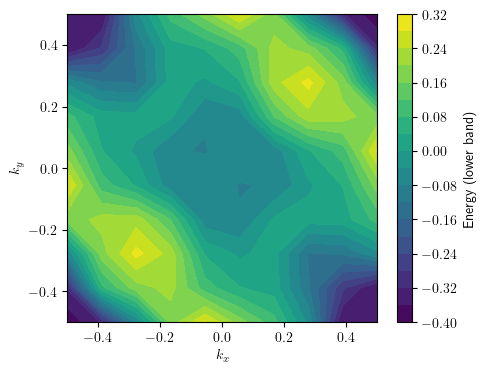

In [29]:
# Generate a random latent vector
random_vector = torch.randn(1, latent_dim)

# Decode the random vector to get an output image
with torch.no_grad():
    random_decoded_output = model.decode(random_vector).cpu().detach().numpy()

plot_im(random_decoded_output[0,0])
# plot_im(symm(random_decoded_output[0,0]))

In [28]:
save_checkpoint(checkpoint_path='./AUTOmodel_v4', model=model, optimizer=optimizer)

model saved to ./AUTOmodel_v4


In [15]:
load_checkpoint(checkpoint_path='./AUTOmodel_v4', model=model, optimizer=optimizer)

model loaded from ./AUTOmodel_v4


/tmp/ipykernel_81827/2853960746.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(checkpoint_path)


# Conv

In [58]:
from models.autoenc_conv import Band_generator_conv

In [72]:
latent_dim = 10
learning_rate = 3e-4

model = Band_generator_conv(latent_dim=latent_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [73]:
n_epochs = 100
train_loss2, test_loss2, _ = train_model(model, criterion, optimizer, n_epochs)

Epoch 1 of 100 took 0.477s
	  training loss: 1.066002
	validation loss: 1.047440
Epoch 2 of 100 took 0.489s
	  training loss: 1.033464
	validation loss: 1.014810
Epoch 3 of 100 took 0.480s
	  training loss: 1.002112
	validation loss: 0.984385
Epoch 4 of 100 took 0.519s
	  training loss: 0.958141
	validation loss: 0.927450
Epoch 5 of 100 took 0.407s
	  training loss: 0.890431
	validation loss: 0.845216
Epoch 6 of 100 took 0.381s
	  training loss: 0.804427
	validation loss: 0.760349
Epoch 7 of 100 took 0.386s
	  training loss: 0.750291
	validation loss: 0.742093
Epoch 8 of 100 took 0.396s
	  training loss: 0.721653
	validation loss: 0.701522
Epoch 9 of 100 took 0.427s
	  training loss: 0.704428
	validation loss: 0.687794
Epoch 10 of 100 took 0.409s
	  training loss: 0.681318
	validation loss: 0.665088
Epoch 11 of 100 took 0.510s
	  training loss: 0.656760
	validation loss: 0.621058
Epoch 12 of 100 took 0.403s
	  training loss: 0.615926
	validation loss: 0.588125
Epoch 13 of 100 took 0.40

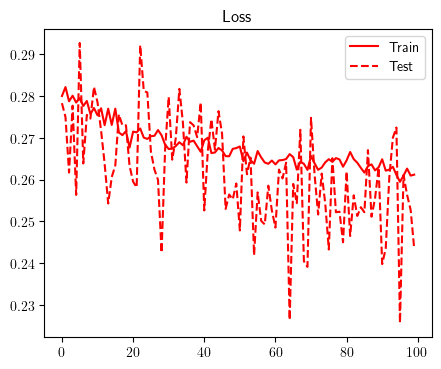

In [71]:
plot_train_process(train_loss2, test_loss2)

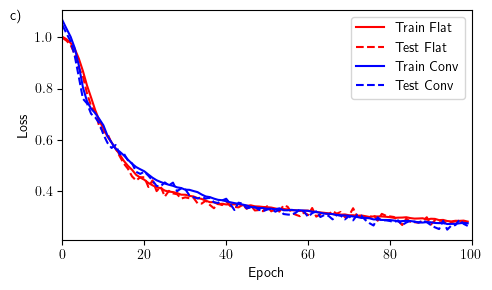

In [80]:
def plot_train_process2(train_loss1, test_loss1, train_loss2, test_loss2):
    fig, axes = plt.subplots(1, 1, figsize=( 5, 3))

    # axes.set_title('Loss')
    axes.text(-0.1, 1.0, 'c)', transform=axes.transAxes,
        fontsize=10, fontweight='normal', va='top', ha='right')
    
    axes.plot(train_loss1, linestyle='solid', color='red', label='Train Flat')
    axes.plot(test_loss1,  linestyle='dashed', color='red', label='Test Flat')

    axes.plot(train_loss2, linestyle='solid', color='blue', label='Train Conv')
    axes.plot(test_loss2,  linestyle='dashed', color='blue', label='Test Conv')
    axes.set_xlim((0, 100))
    axes.set_xlabel('Epoch')
    axes.set_ylabel('Loss')
    fig.tight_layout()
    
    axes.legend()


plot_train_process2(train_loss, test_loss, train_loss2, test_loss2)